"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [2]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum
import sys
sys.path.append('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize
import pandas as pd

sys.path.append('/media/bigdata/projects/pytau')
import pytau

import itertools as it
from tqdm import tqdm

In [101]:
#data_dir = '/media/bigdata/firing_space_plot/changepoint_mcmc/ipython_notebooks/'
data_dir = '/media/fastdata/VF350_SUC1_190327_121132_repacked/'
dat = ephys_data(data_dir)
dat.get_spikes()
dat.firing_rate_params = dat.default_firing_params
dat.get_firing_rates()
#spikes = np.load(os.path.join(data_dir,'km36_day1_dig3_suc.spikes.npy'))
#lasers = np.load(os.path.join(data_dir,'km36_day1_dig3_suc.laser.npy'))

All tastes have equal dimensions,concatenating and normalizing


In [11]:
data_vec = np.squeeze(np.array(dat.spikes))

In [12]:
#data_vec = spikes[np.where(lasers)[0]]
time_lims = [2000,4000]
data_vec = data_vec[...,time_lims[0]:time_lims[1]]

In [13]:
bin_width = 50
spike_array = np.sum(np.reshape(data_vec,(*data_vec.shape[:2],-1,bin_width)),axis=-1)
print(spike_array.shape)

(120, 15, 40)


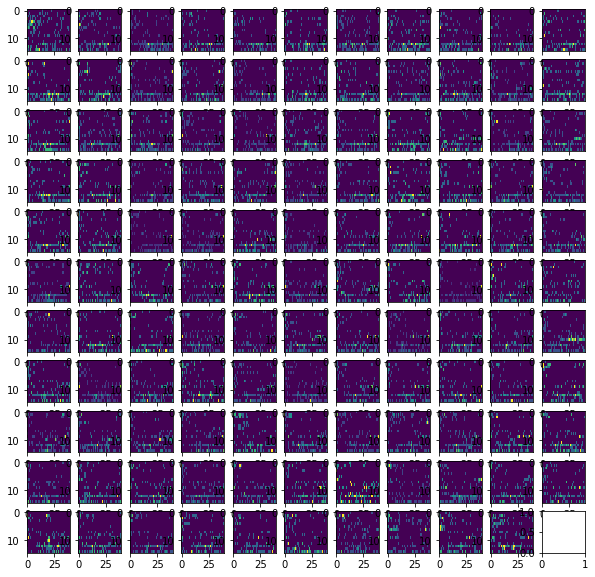

In [166]:
fig,ax = visualize.gen_square_subplots(len(spike_array), figsize = (10,10));
for this_dat, this_ax in zip(spike_array, ax.flatten()):
    this_ax.imshow(this_dat, interpolation='nearest', aspect='auto')

In [15]:
state_list = range(2,7)
comps_list = range(2,5)
iters = list(it.product(state_list, comps_list))

In [16]:
elbo_list = []
model_list = []
approx_list = []
fit = 40000
samples = 20000

In [17]:
#single_taste_poisson_trial_switch(spike_array,switch_components,states)
for this_iter in tqdm(iters):
    model = pytau.changepoint_model.single_taste_poisson_trial_switch(spike_array, this_iter[1], this_iter[0])
    with model:
        inference = pm.ADVI('full-rank')
        approx = pm.fit(n=fit, method=inference)
        #trace = approx.sample(draws=samples)
    
    model_list.append(model)
    approx_list.append(approx)
    elbo_list.append(-approx.hist[-1])

  0%|          | 0/15 [00:00<?, ?it/s]

Finished [100%]: Average Loss = 33,959
  7%|▋         | 1/15 [02:33<35:54, 153.91s/it]

Finished [100%]: Average Loss = 34,000
 13%|█▎        | 2/15 [04:56<32:37, 150.57s/it]

Finished [100%]: Average Loss = 33,966
 20%|██        | 3/15 [07:17<29:33, 147.79s/it]

Finished [100%]: Average Loss = 33,331
 27%|██▋       | 4/15 [09:53<27:32, 150.20s/it]

Finished [100%]: Average Loss = 33,373
 33%|███▎      | 5/15 [12:34<25:33, 153.37s/it]

Finished [100%]: Average Loss = 33,341
 40%|████      | 6/15 [15:14<23:18, 155.40s/it]

Finished [100%]: Average Loss = 33,050
 47%|████▋     | 7/15 [18:11<21:34, 161.76s/it]

Finished [100%]: Average Loss = 33,090
 53%|█████▎    | 8/15 [21:11<19:30, 167.17s/it]

Finished [100%]: Average Loss = 33,097
 60%|██████    | 9/15 [24:11<17:06, 171.02s/it]

Finished [100%]: Average Loss = 33,017
 67%|██████▋   | 10/15 [27:31<14:58, 179.77s/it]

Finished [100%]: Average Loss = 33,059
 73%|███████▎  | 11/15 [31:03<12:38, 189.58s/it]

Finished [100%]: Average Loss = 33,110
 80%|████████  | 12/15 [34:25<09:40, 193.35s/it]

Finished [100%]: Average Loss = 33,056
 87%|████████▋ | 13/15 [38:19<06:50, 205.32s/it]

Finished [100%]: Average Loss = 33,134
 93%|█████████▎| 14/15 [41:59<03:29, 209.78s/it]

Finished [100%]: Average Loss = 33,182
100%|██████████| 15/15 [45:42<00:00, 182.84s/it]


In [18]:
param_array = np.array(iters)
elbo_frame = pd.DataFrame(dict(
                states = param_array[:,0],
                components = param_array[:,1],
                elbo = elbo_list))

## ==== Models with Top 3 ELBO ====

In [24]:
elbo_frame.sort_values('elbo', ascending=False)

,states,components,elbo
9,5,2,-33005.193754
12,6,2,-33037.368046
6,4,2,-33052.092041
13,6,3,-33079.325006
10,5,3,-33080.863363
7,4,3,-33086.020746
8,4,4,-33093.283542
11,5,4,-33131.910974
14,6,4,-33221.201928
3,3,2,-33330.377913


In [33]:
best_model_ind = np.argsort(elbo_list)[-1]#np.argmax(elbo_list)
best_model = model_list[best_model_ind]
best_approx = approx_list[best_model_ind]

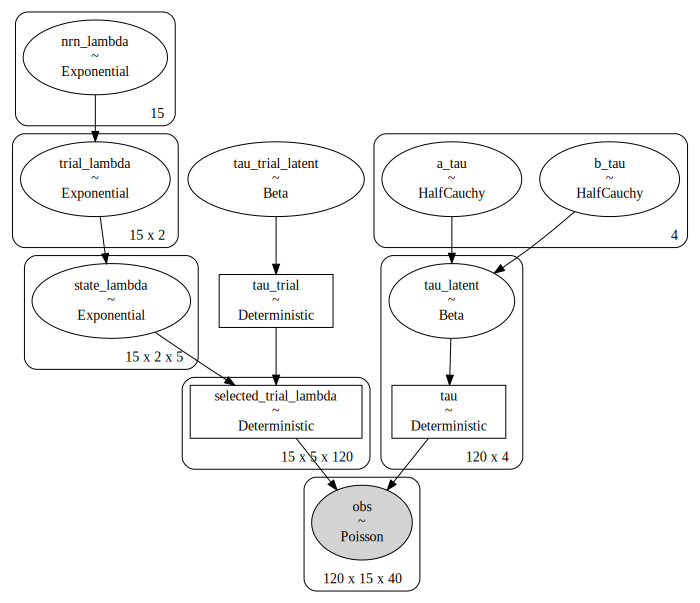

In [37]:
pm.model_to_graphviz(best_model)

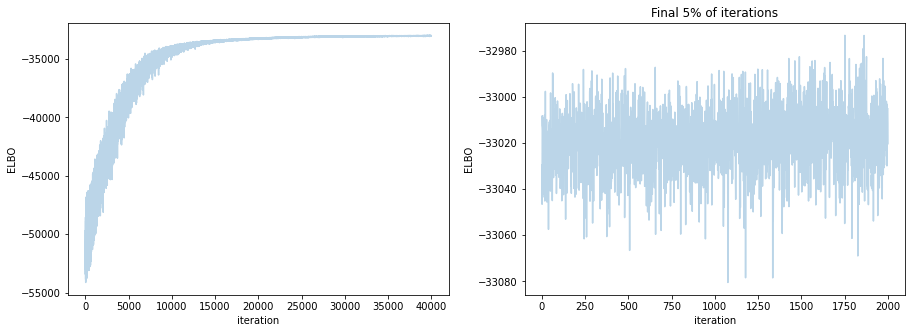

In [34]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(-best_approx.hist, alpha=.3)
ax[0].set_ylabel('ELBO')
ax[0].set_xlabel('iteration');

ind = int(fit - fit*0.05)
ax[1].plot(-best_approx.hist[ind:], alpha=.3)
ax[1].set_title('Final 5% of iterations')
ax[1].set_ylabel('ELBO')
ax[1].set_xlabel('iteration');

In [35]:
with best_model:
    trace = best_approx.sample(draws=samples)

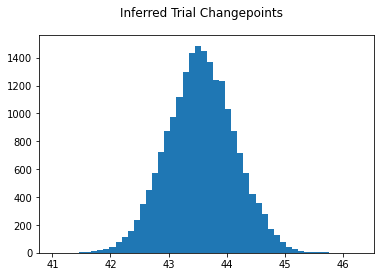

In [36]:
for dist in trace['tau_trial'].T:
    plt.hist(dist,bins = 50);
plt.suptitle('Inferred Trial Changepoints');

In [42]:
# Plot changes in emission
mean_selected_trial_lambda = np.mean(trace['selected_trial_lambda'],axis=0).swapaxes(0,1)
print(mean_selected_trial_lambda.shape)

(5, 15, 120)


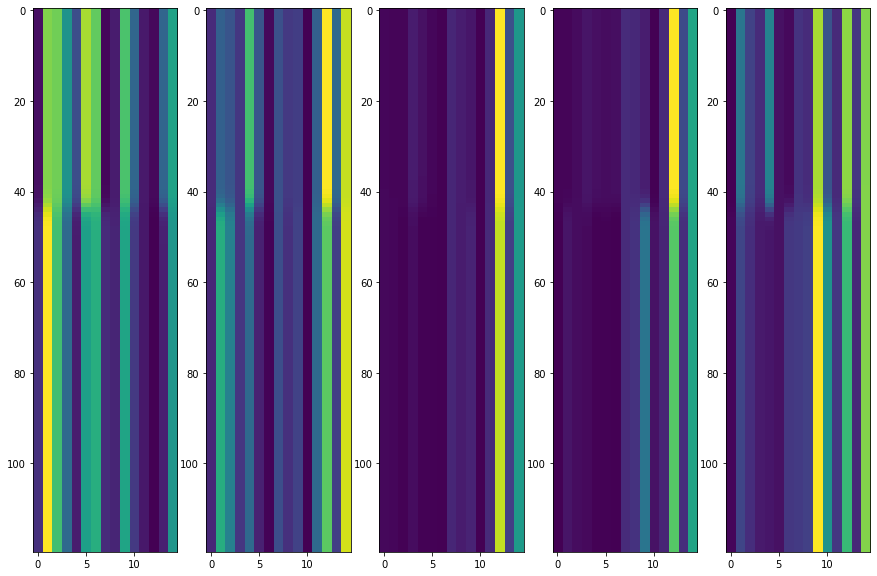

In [47]:
fig,ax = plt.subplots(1,len(mean_selected_trial_lambda), figsize=(15,10))
for this_dat, this_ax in zip(mean_selected_trial_lambda, ax):
    this_ax.imshow(this_dat.T, interpolation='nearest', aspect='auto')

In [57]:
tau_stack = trace['tau']
int_tau = np.vectorize(np.int)(tau_stack)
mode_tau = np.squeeze(stats.mode(int_tau,axis=0)[0])

Text(0, 0.5, 'Trial Number')

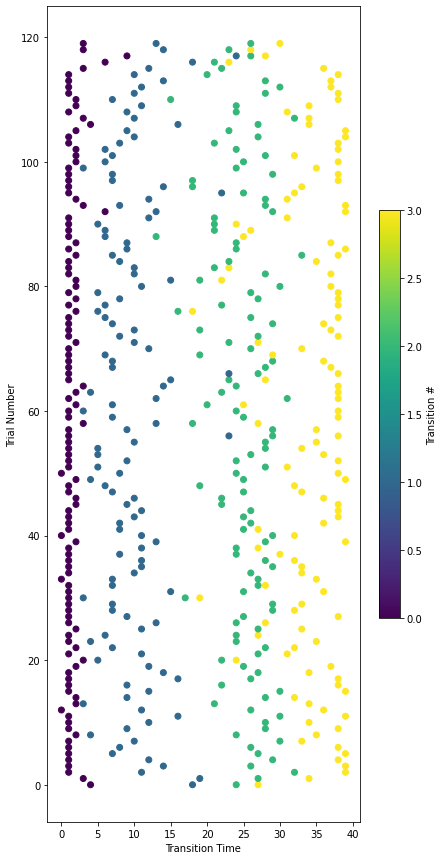

In [71]:
fig,ax = plt.subplots(figsize = (7,15))
for num, vals in enumerate(mode_tau):
    im = ax.scatter(vals,[num]*len(vals), c = range(len(vals)))
plt.colorbar(im, shrink = 0.5, label = 'Transition #')
plt.xlabel('Transition Time')
plt.ylabel('Trial Number')

In [81]:
trial_switch_ind = np.squeeze(stats.mode(np.vectorize(np.int)(trace['tau_trial']))[0])
trial_membership = tt.nnet.sigmoid(np.arange(len(mode_tau)) - trial_switch_ind).eval()

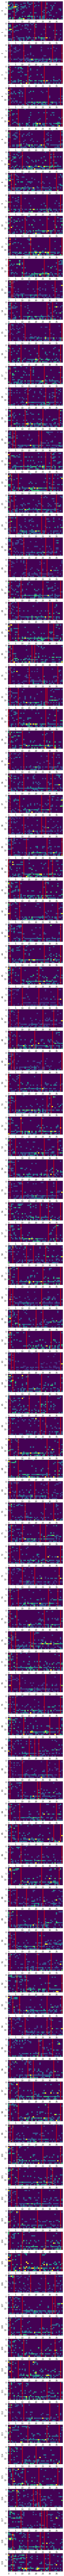

In [177]:
fig,ax = plt.subplots(len(spike_array),1, figsize = (5,240))
for ind in range(mode_tau.shape[0]):
    this_tau = mode_tau[ind]
    this_dat = spike_array[ind]
    this_ax = ax.flatten()[ind]
    this_ax.imshow(this_dat, interpolation='nearest', aspect='auto')
    this_ax.vlines(this_tau, -0.5, this_dat.shape[0]-0.5, 
                   color = 'red', linewidth = 5, alpha = 0.5)
    this_ax.set_ylabel(ind)

## PCA of firing colored by trial membership

In [154]:
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from sklearn.decomposition import NMF, PCA

In [122]:
lim_inds = [int(x/25) for x in time_lims]
firing_array = np.squeeze(dat.firing_array)[...,lim_inds[0]:lim_inds[1]]

In [132]:
#spike_array_long = spike_array.swapaxes(0,1)
#spike_array_long = spike_array_long.reshape(spike_array_long.shape[0],-1)
firing_long = firing_array.reshape(firing_array.shape[0],-1)
scaler_obj = MinMaxScaler().fit(firing_long.T)
scaled_firing_long = scaler_obj.transform(firing_long.T).T

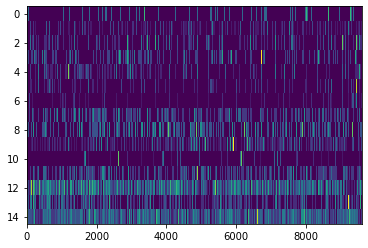

In [133]:
plt.imshow(scaled_firing_long, interpolation='nearest',aspect='auto')

In [155]:
nmf_obj = PCA(n_components = 3).fit(scaled_firing_long.T)
nmf_firing_long = nmf_obj.transform(scaled_firing_long.T).T

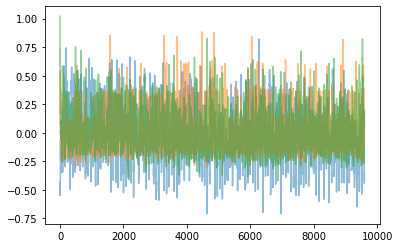

In [156]:
plt.plot(nmf_firing_long.T, alpha = 0.5);

In [157]:
firing_array_temp = firing_array.swapaxes(0,1)
scaled_firing = np.stack([scaler_obj.transform(x.T).T for x in firing_array_temp])
nmf_firing = np.stack([nmf_obj.transform(x.T).T for x in scaled_firing])


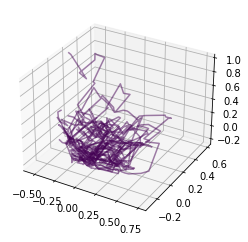

In [160]:
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=1)
colors = cmap(norm(trial_membership))

ax = plt.axes(projection='3d')
for num, trial in enumerate(nmf_firing[:10]):
    ax.plot3D(*trial, c = colors[num], alpha = 0.5)

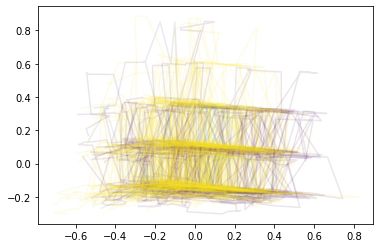

In [164]:
fig,ax = plt.subplots()
for num, trial in enumerate(nmf_firing):
    ax.plot(*trial[:2], c = colors[num], alpha = 0.1)